In [1]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/processedData.csv')
df.head()

,owner,age,selling_price,km_driven,car_design_type,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,fule_Other
0,1.0,14,60000,70000,1.0,0,1,0,1,0,0,1,0
1,1.0,14,135000,50000,1.0,0,1,0,1,0,0,1,0
2,1.0,9,600000,100000,3.0,1,0,0,1,0,0,1,0
3,1.0,4,250000,46000,1.0,0,1,0,1,0,0,1,0
4,2.0,7,450000,141000,3.0,1,0,0,1,0,0,1,0


In [ ]:
!nvidia-smi

Sat Dec 30 06:53:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
df.shape

(4335, 13)

In [4]:
df.drop(['fule_Other','seller_type_Trustmark Dealer','transmission_Automatic'], axis=1, inplace=True)

In [5]:
df.head()

,owner,age,selling_price,km_driven,car_design_type,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,transmission_Manual
0,1.0,14,60000,70000,1.0,0,1,0,1,1
1,1.0,14,135000,50000,1.0,0,1,0,1,1
2,1.0,9,600000,100000,3.0,1,0,0,1,1
3,1.0,4,250000,46000,1.0,0,1,0,1,1
4,2.0,7,450000,141000,3.0,1,0,0,1,1


## Correlation Analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

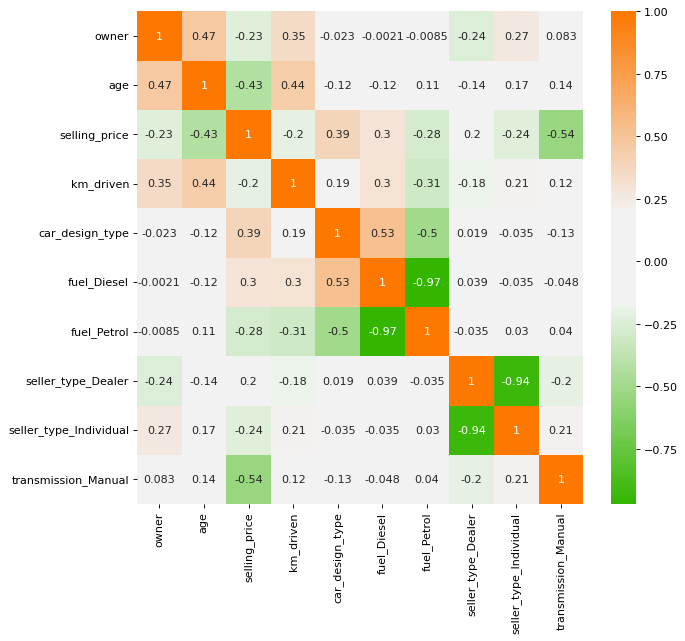

In [7]:
cmap = sns.diverging_palette(125,28,s=100,l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(df.corr(), cmap=cmap, annot=True)
plt.show()

### Conclusions
1. owner and age are +vely correlated
2. km_driven and age are +vely correlated
3. age and selling_price are -vely correlated
4. selling price & transmission_manual are -vely correlated
5. fule_petrol & fuel_desil are highly -vely correlated because 97% of the cars are either petrol or desiel and 3% cars are CNG/LPG/electric

#### Split Dataset to Training & Test Sets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('selling_price', axis = 1), df['selling_price'], test_size=0.30, random_state=10)

In [10]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (3034, 9)
X_test shape:  (1301, 9)
y_train shape:  (3034,)
y_test shape:  (1301,)


#### Scale Data using Standard Scaler

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
X_test_scaled

array([[-0.62021238, -0.22643097, -0.81819553, ..., -0.54001246,
         0.57760399,  0.33976636],
       [ 0.7654462 ,  0.00981097, -1.46503778, ...,  1.85180914,
        -1.73128997,  0.33976636],
       [ 2.15110478, -0.22643097,  1.18924594, ..., -0.54001246,
         0.57760399,  0.33976636],
       ...,
       [-0.62021238, -0.93515681, -0.32748762, ...,  1.85180914,
        -1.73128997,  0.33976636],
       [-0.62021238, -1.17139876, -0.706671  , ..., -0.54001246,
         0.57760399,  0.33976636],
       [ 3.53676336,  3.08095626,  0.48664142, ..., -0.54001246,
         0.57760399,  0.33976636]])

### Train Models

In [20]:
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn import metrics
from sklearn.metrics import r2_score
def evaluate_models(X_train,y_train, X_test,y_test, models:dict, params:dict):
    model_keys = models.keys()
    report = {}

    for model_name in model_keys:
        model = models[model_name]
        parameters = params[model_name]

        scoring = {"MSE" : metrics.make_scorer(metrics.mean_squared_error),
                   "MAE": metrics.make_scorer(metrics.mean_absolute_error),
                   "R_2": metrics.make_scorer(metrics.r2_score)}
        # GridSearchCV will get best hypermaters for each model
        gs = GridSearchCV(estimator=model, param_grid=parameters, cv=5, refit=True)
        gs.fit(X_train, y_train)

        # now test the model with training data
        """k_folds = KFold(n_splits=3)
        cv_scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
        result = cross_validate(estimator=gs.best_estimator_,X=X_test, y=y_test, cv=k_folds, scoring = cv_scoring, return_train_score=True)

        MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
        MSE_mean = (-result['test_neg_mean_squared_error']).mean()
        RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
        R2_Score_mean = result['test_r2'].mean()
        report[model_name] = {
                                "Scores": {"MAE": MAE_mean,
                              "MSE": MSE_mean,
                              "RMSE":RMSE_mean,
                              "R2": R2_Score_mean},
                                "Best Parameters":gs.best_params_
        }"""
        model.set_params(**gs.best_params_)
        model.fit(X_train,y_train)
        y_test_pred = model.predict(X_test)
        test_model_score = r2_score(y_test, y_test_pred)

        y_train_pred = model.predict(X_train)
        train_model_score = r2_score(y_train, y_train_pred)
        report[model_name] = {
          'R2_score_test' : test_model_score,
          'R@_score_train' : train_model_score,
          'best_params': gs.best_params_
        }

    return report





In [ ]:
#%pip install xgboost

In [22]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
models = {
    #"Linear Regression": LinearRegression(),
    #"Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    #"Lasso": Lasso(),
    #"SVR":SVR(),
    #"Elastic Net": ElasticNet(max_iter=1000000),
    #"XGBRegressor": XGBRegressor(),
    #"AdaBoost Regressor": AdaBoostRegressor(),
    #"Gradient Boosting": GradientBoostingRegressor(),
    "Ridge Regression" : Ridge()
}

params = {
    "Linear Regression":{
        'n_jobs':[-1]
    },
    "Random Forest":{
                    # 'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],

                    'max_features':['sqrt','log2',None],
                    'n_estimators': [4,8,16,32,64,128,256],
                    'max_depth':[3,5,7,9],
                    'n_jobs':[-1]
                },
    "Decision Tree": {
                    #'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                    'splitter':['best','random'],
                    'max_features':['sqrt','log2'],
                    'n_jobs':[-1]
                },
    "Lasso":{
        'alpha':[1e-15,1e-10,0.1, 2, 0.5, 0.9, 1,5,10,20,30,35,40,45,50,55,100]
    },
    "Ridge Regression" :{
      'alpha':[1e-2,1,5,10,20,30,35,40,45,50,55,100]
    },
    "SVR": {
        'kernel': ['linear', 'poly', 'rbf'],

        'C':[1, 25, 57],
        'epsilon':[0.1, 0.01, 0.001]
    },
    "Elastic Net": {
        'alpha':[0.9, 1, 5],
        'l1_ratio':[0.8,1],
        #'tol': [0.01, 0.1]
    },
    "Gradient Boosting":{
        # 'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
        'learning_rate':[.1,.01,.05,.001],
        'subsample':[0.75,0.8,0.85,0.9],
        # 'criterion':['squared_error', 'friedman_mse'],
        'max_features':['sqrt','log2'],
        'n_estimators': [32,64,128,256, 512],
        'max_depth':[3,5,6],
    },
    "XGBRegressor":{
        'learning_rate':[.01,.05,.001],
        'n_estimators': [32,64,128,256],
        'max_depth':[3,5,10],
        'n_jobs':[-1]
    },
    "CatBoosting Regressor":{
        'depth': [6,8,10],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [30, 50, 100],
        'n_jobs':[-1]
    },
    "AdaBoost Regressor":{
        'learning_rate':[.1,.01,0.5,.001],
        #'loss':['linear','square','exponential'],
        'n_estimators': [8,16,32,64,128,256],
    }
}

In [16]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

In [17]:
# feature selection
def select_features(X_train, y_train, X_test, k=20):
 k = k if X_train.shape[1] >k else X_train.shape[1]
 fs = SelectKBest(score_func=mutual_info_regression, k=k)
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

In [23]:
evaluate_models(X_train=X_train_scaled, y_train=y_train,X_test=X_test_scaled, y_test=y_test, models=models, params=params)

{'Random Forest': {'R2_score_test': 0.6542480450787584,
  'R@_score_train': 0.9174914034650747,
  'best_params': {'max_depth': 9,
   'max_features': None,
   'n_estimators': 16,
   'n_jobs': -1}}}

In [ ]:
gred = GridSearchCV(RandomForestRegressor(), {
    'criterion':[ 'absolute_error'],
    'max_features':['sqrt','log2'],
    'n_estimators': [90,95,100,120,125],
    'max_depth':[9,10,11,12, 13],
}, cv=4)
gred.fit(X_train_scaled,y_train)
print(gred.best_params_)


In [ ]:
model = RandomForestRegressor()
model.set_params(**gred.best_params_)
model.fit(X_train_scaled,y_train)
y_test_pred = model.predict(X_test_scaled)
test_model_score = r2_score(y_test, y_test_pred)
print("test_model_score : ", test_model_score)
y_train_pred = model.predict(X_train_scaled)
train_model_score = r2_score(y_train, y_train_pred)
print("train_model_score : ", train_model_score)

In [54]:
gred_df = pd.DataFrame(gred.cv_results_)

gred_df[['param_max_depth','param_max_features','param_n_estimators','param_criterion','mean_test_score','rank_test_score']]

,param_max_depth,param_max_features,param_n_estimators,param_criterion,mean_test_score,rank_test_score
0,8,sqrt,95,absolute_error,0.767532,111
1,8,sqrt,100,absolute_error,0.767469,112
2,8,sqrt,105,absolute_error,0.767825,109
3,8,sqrt,110,absolute_error,0.769453,105
4,8,sqrt,120,absolute_error,0.772026,102
...,...,...,...,...,...,...
107,17,log2,110,absolute_error,0.777407,85
108,17,log2,120,absolute_error,0.777552,84
109,17,log2,125,absolute_error,0.775198,94
110,17,log2,130,absolute_error,0.782514,18


## Build Higher Order Regularized Polynomial Mode

In [ ]:
from sklearn.preprocessing import PolynomialFeatures


def poly_check(degree, X, y, max_features=20):
    result = {}
    for d in range(2,degree+1):
        poly_features = PolynomialFeatures(degree=d, include_bias=False)
        X_poly = poly_features.fit_transform(X)
        X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=10)

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, k=max_features)


        #res = {'degree': d,'result': evaluate_models(X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, models=models, params=params)}
        res = evaluate_models(X_train=X_train_fs, y_train=y_train, X_test=X_test_fs,y_test=y_test, models=models, params=params)
        print(res)
        result[d] = res
    return result



In [ ]:
poly_check(4, df.drop('selling_price', axis = 1), df['selling_price'], max_features=30)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e+14, tolerance: 6.262e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+14, tolerance: 5.146e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.411e+14, tolerance: 6.032e

{'Linear Regression': {'R2_score_test': 0.47246155239183296, 'R@_score_train': 0.5249662692087238, 'best_params': {'n_jobs': -1}}, 'Lasso': {'R2_score_test': 0.4718750259767053, 'R@_score_train': 0.524852296920874, 'best_params': {'alpha': 100}}, 'Ridge Regression': {'R2_score_test': 0.4686394706775039, 'R@_score_train': 0.5239097764040443, 'best_params': {'alpha': 10}}}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e+14, tolerance: 6.262e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+14, tolerance: 5.146e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.538e+14, tolerance: 6.032e

{'Linear Regression': {'R2_score_test': 0.4525549884280393, 'R@_score_train': 0.4873447861953032, 'best_params': {'n_jobs': -1}}, 'Lasso': {'R2_score_test': 0.450374944333762, 'R@_score_train': 0.4871943514399055, 'best_params': {'alpha': 100}}, 'Ridge Regression': {'R2_score_test': 0.44447067155392106, 'R@_score_train': 0.4821237140072171, 'best_params': {'alpha': 10}}}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e+14, tolerance: 6.262e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+14, tolerance: 5.146e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e+14, tolerance: 6.032e

{'Linear Regression': {'R2_score_test': 0.38644255465421373, 'R@_score_train': 0.4414305793048595, 'best_params': {'n_jobs': -1}}, 'Lasso': {'R2_score_test': 0.3894254090114444, 'R@_score_train': 0.4327490455940223, 'best_params': {'alpha': 1e-15}}, 'Ridge Regression': {'R2_score_test': 0.3876257047410818, 'R@_score_train': 0.4346338097503861, 'best_params': {'alpha': 1}}}


{2: {'Linear Regression': {'R2_score_test': 0.47246155239183296,
   'R@_score_train': 0.5249662692087238,
   'best_params': {'n_jobs': -1}},
  'Lasso': {'R2_score_test': 0.4718750259767053,
   'R@_score_train': 0.524852296920874,
   'best_params': {'alpha': 100}},
  'Ridge Regression': {'R2_score_test': 0.4686394706775039,
   'R@_score_train': 0.5239097764040443,
   'best_params': {'alpha': 10}}},
 3: {'Linear Regression': {'R2_score_test': 0.4525549884280393,
   'R@_score_train': 0.4873447861953032,
   'best_params': {'n_jobs': -1}},
  'Lasso': {'R2_score_test': 0.450374944333762,
   'R@_score_train': 0.4871943514399055,
   'best_params': {'alpha': 100}},
  'Ridge Regression': {'R2_score_test': 0.44447067155392106,
   'R@_score_train': 0.4821237140072171,
   'best_params': {'alpha': 10}}},
 4: {'Linear Regression': {'R2_score_test': 0.38644255465421373,
   'R@_score_train': 0.4414305793048595,
   'best_params': {'n_jobs': -1}},
  'Lasso': {'R2_score_test': 0.3894254090114444,
   'R@_s

In [ ]:
!nvidia-smi

Sat Dec 30 07:49:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
X = df.drop('selling_price', axis = 1)
y = df['selling_price']

In [ ]:
from matplotlib import pyplot
import numpy as np

def poly(d, max_features=20):
  poly_features = PolynomialFeatures(degree=d, include_bias=False)
  X_poly = poly_features.fit_transform(X)
  X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
  X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=10)


  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, k=max_features)
  mask = fs.get_support()
  new_features = X_poly.columns[mask]


  top_k_indices = np.argsort(fs.scores_)[::-1][:max_features]

  # Get the names of the top k features
  feature_names = np.array(poly_features.get_feature_names_out(X.columns))
  top_k_feature_names = feature_names[top_k_indices]

  # Get the scores of the top k features
  top_k_scores = fs.scores_[top_k_indices]

  print("Top {} features:".format(max_features))
  for name, score in zip(top_k_feature_names, top_k_scores):
      print("{}: {:.4f}".format(name, score))


  # plot the scores
  pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
  pyplot.show()


  #res = {'degree': d,'result': evaluate_models(X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, models=models, params=params)}
  res = evaluate_models(X_train=X_train_fs, y_train=y_train, X_test=X_test_fs,y_test=y_test, models=models, params=params)
  return res

Top 25 features:
age transmission_Manual: 0.5591
age car_design_type: 0.5433
age^2: 0.5084
age km_driven: 0.5050
age: 0.4881
age seller_type_Individual: 0.4441
owner age: 0.4159
age fuel_Petrol: 0.4017
owner km_driven: 0.3998
km_driven car_design_type: 0.3968
km_driven transmission_Manual: 0.3893
km_driven: 0.3823
km_driven^2: 0.3780
age fuel_Diesel: 0.3630
km_driven fuel_Diesel: 0.3354
km_driven fuel_Petrol: 0.3061
car_design_type transmission_Manual: 0.2996
owner car_design_type: 0.2607
car_design_type seller_type_Individual: 0.2346
car_design_type: 0.2336
km_driven seller_type_Individual: 0.2246
age seller_type_Dealer: 0.2208
car_design_type^2: 0.2191
km_driven seller_type_Dealer: 0.2100
owner transmission_Manual: 0.1955


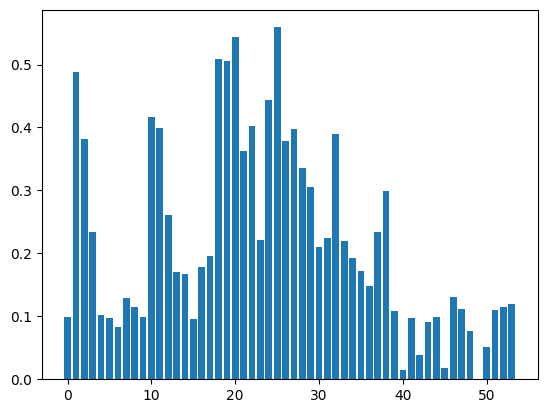

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e+14, tolerance: 6.262e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.183e+13, tolerance: 5.146e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+14, tolerance: 6.032e

{'Linear Regression': {'R2_score_test': 0.6187367786789998,
  'R@_score_train': 0.6436748572430878,
  'best_params': {'n_jobs': -1}},
 'Random Forest': {'R2_score_test': 0.7018316648001011,
  'R@_score_train': 0.930062593177925,
  'best_params': {'max_depth': 10,
   'max_features': 'log2',
   'n_estimators': 64,
   'n_jobs': -1}},
 'Lasso': {'R2_score_test': 0.6189623863975252,
  'R@_score_train': 0.6436339985462161,
  'best_params': {'alpha': 100}},
 'SVR': {'R2_score_test': 0.19520703281691143,
  'R@_score_train': 0.22872357735642856,
  'best_params': {'C': 57, 'epsilon': 0.001, 'kernel': 'linear'}},
 'Elastic Net': {'R2_score_test': 0.6187452799176603,
  'R@_score_train': 0.6436746483228243,
  'best_params': {'alpha': 5, 'l1_ratio': 1}},
 'XGBRegressor': {'R2_score_test': 0.6920996491442941,
  'R@_score_train': 0.8843042900312929,
  'best_params': {'learning_rate': 0.05,
   'max_depth': 5,
   'n_estimators': 64,
   'n_jobs': -1}},
 'AdaBoost Regressor': {'R2_score_test': 0.617546960

In [ ]:
poly(2, 25)

Top 20 features:
age car_design_type^2: 0.7424
age^2 km_driven: 0.5987
age transmission_Manual: 0.5648
age transmission_Manual^2: 0.5552
age^2 transmission_Manual: 0.5542
age car_design_type transmission_Manual: 0.5536
age car_design_type: 0.5440
age km_driven transmission_Manual: 0.5126
age km_driven^2: 0.5090
owner age km_driven: 0.4968
age^2 car_design_type: 0.4952
age km_driven: 0.4938
age^2: 0.4925
owner age transmission_Manual: 0.4914
age: 0.4890
age^3: 0.4862
age seller_type_Individual transmission_Manual: 0.4730
owner age^2: 0.4713
owner^2 age: 0.4552
km_driven car_design_type^2: 0.4541


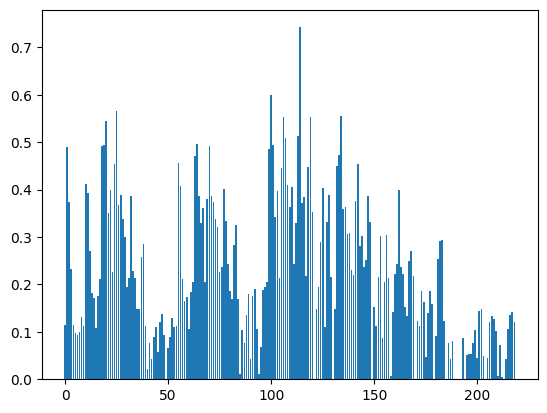

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+14, tolerance: 6.262e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+14, tolerance: 5.146e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e+14, tolerance: 6.032e

{'Linear Regression': {'R2_score_test': 0.46549624568896675,
  'R@_score_train': 0.5236769229882681,
  'best_params': {'n_jobs': -1}},
 'Random Forest': {'R2_score_test': 0.6850788432084818,
  'R@_score_train': 0.9047271509320782,
  'best_params': {'max_depth': 10,
   'max_features': 'sqrt',
   'n_estimators': 64,
   'n_jobs': -1}},
 'Lasso': {'R2_score_test': 0.4660283789402888,
  'R@_score_train': 0.523621729925331,
  'best_params': {'alpha': 100}},
 'SVR': {'R2_score_test': 0.1426687732472396,
  'R@_score_train': 0.17088369252550073,
  'best_params': {'C': 57, 'epsilon': 0.1, 'kernel': 'linear'}},
 'Elastic Net': {'R2_score_test': 0.4655157400708253,
  'R@_score_train': 0.5236766860607809,
  'best_params': {'alpha': 5, 'l1_ratio': 1}},
 'XGBRegressor': {'R2_score_test': 0.676752719680588,
  'R@_score_train': 0.825677097391726,
  'best_params': {'learning_rate': 0.05,
   'max_depth': 3,
   'n_estimators': 256,
   'n_jobs': -1}},
 'AdaBoost Regressor': {'R2_score_test': 0.589551069845

In [ ]:
poly(3)

Top 20 features:
age car_design_type^3: 0.7802
age car_design_type^2: 0.7526
age car_design_type^2 transmission_Manual: 0.7117
age^3 km_driven: 0.6411
age^3 car_design_type: 0.6200
age^2 km_driven: 0.6059
age^2 km_driven transmission_Manual: 0.6032
age car_design_type^2 seller_type_Individual: 0.5855
owner age^2 km_driven: 0.5605
age car_design_type transmission_Manual^2: 0.5598
age^2 transmission_Manual: 0.5594
age car_design_type transmission_Manual: 0.5591
age^2 transmission_Manual^2: 0.5560
age transmission_Manual^2: 0.5545
age car_design_type: 0.5535
age transmission_Manual^3: 0.5522
age^3 transmission_Manual: 0.5506
age transmission_Manual: 0.5479
owner age^2 transmission_Manual: 0.5433
owner^2 age km_driven: 0.5282


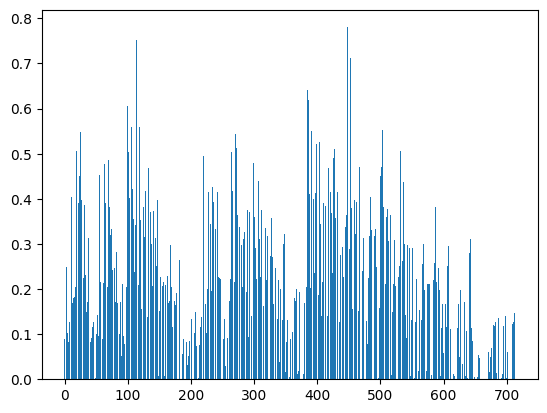

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e+14, tolerance: 6.262e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+14, tolerance: 5.146e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+14, tolerance: 6.032e

{'Linear Regression': {'R2_score_test': 0.47913432650069354,
  'R@_score_train': 0.5037040434647229,
  'best_params': {'n_jobs': -1}},
 'Random Forest': {'R2_score_test': 0.6854138619133593,
  'R@_score_train': 0.9080192297571115,
  'best_params': {'max_depth': 10,
   'max_features': 'log2',
   'n_estimators': 32,
   'n_jobs': -1}},
 'Lasso': {'R2_score_test': 0.47346481534634377,
  'R@_score_train': 0.5023657077190473,
  'best_params': {'alpha': 50}},
 'SVR': {'R2_score_test': 0.143951315713706,
  'R@_score_train': 0.17296962053432097,
  'best_params': {'C': 57, 'epsilon': 0.001, 'kernel': 'linear'}},
 'Elastic Net': {'R2_score_test': 0.47912111886983855,
  'R@_score_train': 0.5037040266352212,
  'best_params': {'alpha': 0.9, 'l1_ratio': 1}},
 'XGBRegressor': {'R2_score_test': 0.6773156114891574,
  'R@_score_train': 0.8269175304744644,
  'best_params': {'learning_rate': 0.05,
   'max_depth': 3,
   'n_estimators': 256,
   'n_jobs': -1}},
 'AdaBoost Regressor': {'R2_score_test': 0.60001

In [ ]:
poly(4)

Top 20 features:
age car_design_type^3: 0.7695
age car_design_type^2: 0.7565
age car_design_type^4: 0.7412
age car_design_type^2 transmission_Manual^2: 0.7230
age car_design_type^2 transmission_Manual: 0.7179
age car_design_type^3 transmission_Manual: 0.7101
age^4 km_driven: 0.6644
age^2 car_design_type^3: 0.6568
age^3 km_driven: 0.6402
owner age^3 km_driven: 0.6273
age^3 km_driven transmission_Manual: 0.6243
owner age car_design_type^3: 0.6212
age^3 car_design_type transmission_Manual: 0.6174
age^2 km_driven: 0.6087
age^2 km_driven transmission_Manual: 0.6071
age^3 car_design_type: 0.6011
age^2 km_driven transmission_Manual^2: 0.5987
age car_design_type^3 seller_type_Individual: 0.5978
age km_driven car_design_type^3: 0.5895
age^4 car_design_type: 0.5866


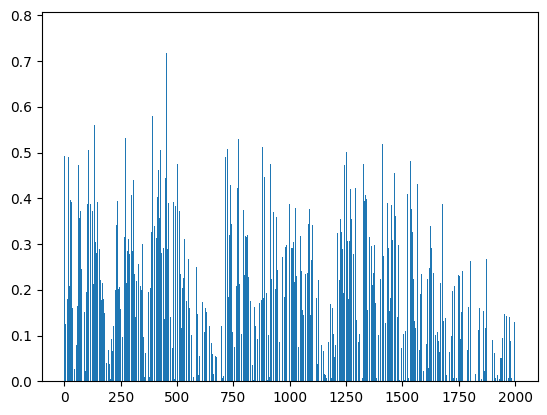

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e+14, tolerance: 6.262e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+14, tolerance: 5.146e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e+14, tolerance: 6.032e

{'Linear Regression': {'R2_score_test': 0.4411296201835877,
  'R@_score_train': 0.49063988734524644,
  'best_params': {'n_jobs': -1}},
 'Random Forest': {'R2_score_test': 0.6936173046046279,
  'R@_score_train': 0.9078856386941205,
  'best_params': {'max_depth': 10,
   'max_features': 'log2',
   'n_estimators': 128,
   'n_jobs': -1}},
 'Lasso': {'R2_score_test': 0.43990665677324736,
  'R@_score_train': 0.456976103168208,
  'best_params': {'alpha': 100}},
 'SVR': {'R2_score_test': 0.025342417828919772,
  'R@_score_train': 0.03906385248732713,
  'best_params': {'C': 57, 'epsilon': 0.1, 'kernel': 'linear'}},
 'Elastic Net': {'R2_score_test': 0.4416196729887053,
  'R@_score_train': 0.4906359236915522,
  'best_params': {'alpha': 5, 'l1_ratio': 1}},
 'XGBRegressor': {'R2_score_test': 0.6930349471874979,
  'R@_score_train': 0.8280719156804252,
  'best_params': {'learning_rate': 0.05,
   'max_depth': 3,
   'n_estimators': 256,
   'n_jobs': -1}},
 'AdaBoost Regressor': {'R2_score_test': 0.601202

In [ ]:
poly(5)

In [ ]:
df.head()

,owner,age,name,selling_price,km_driven,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,transmission_Manual
0,1.0,14,775,60000,70000,0,1,0,1,1
1,1.0,14,1041,135000,50000,0,1,0,1,1
2,1.0,9,505,600000,100000,1,0,0,1,1
3,1.0,4,118,250000,46000,0,1,0,1,1
4,2.0,7,279,450000,141000,1,0,0,1,1


In [ ]:
%pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
#Initialising ANN
ann = tf.keras.models.Sequential()
#Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=8,activation="relu", input_dim=X_train.shape[1]))
ann.add(tf.keras.layers.Dense(units=16,activation="relu"))
ann.add(tf.keras.layers.Dropout(0.2))
ann.add(tf.keras.layers.Dense(units=32,activation="relu"))
ann.add(tf.keras.layers.Dense(units=64,activation="relu"))
ann.add(tf.keras.layers.Dropout(0.2))
ann.add(tf.keras.layers.Dense(units=32,activation="relu"))
ann.add(tf.keras.layers.Dense(units=16,activation="relu"))
ann.add(tf.keras.layers.Dropout(0.2))
ann.add(tf.keras.layers.Dense(units=8,activation="relu"))
ann.add(tf.keras.layers.Dense(units=4,activation="relu"))
ann.add(tf.keras.layers.Dropout(0.2))
ann.add(tf.keras.layers.Dense(units=2,activation="relu"))

ann.add(tf.keras.layers.Dense(units=1,activation="linear"))

In [ ]:
y_train.shape

(3034,)

In [ ]:
ann.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2

In [ ]:
ann.compile(loss='mean_squared_error', optimizer="Adam")

In [ ]:
history = ann.fit(x=X_train,y=y_train, batch_size=20, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
122/122 [==============================] - 7s 7ms/step - loss: 507182415872.0000 - val_loss: 332910231552.0000
Epoch 2/100
122/122 [==============================] - 1s 6ms/step - loss: 465782964224.0000 - val_loss: 341443969024.0000
Epoch 3/100
122/122 [==============================] - 1s 6ms/step - loss: 467499712512.0000 - val_loss: 347580235776.0000
Epoch 4/100
122/122 [==============================] - 1s 6ms/step - loss: 462585462784.0000 - val_loss: 353841971200.0000
Epoch 5/100
122/122 [==============================] - 1s 7ms/step - loss: 467670925312.0000 - val_loss: 339084410880.0000
Epoch 6/100
122/122 [==============================] - 1s 8ms/step - loss: 464134799360.0000 - val_loss: 350491672576.0000
Epoch 7/100
122/122 [==============================] - 1s 8ms/step - loss: 465211293696.0000 - val_loss: 348784754688.0000
Epoch 8/100
122/122 [==============================] - 1s 6ms/step - loss: 470810394624.0000 - val_loss: 341119270912.0000
Epoch 9/100
122/

In [ ]:
y_test_pred_ann = ann.predict(X_test)
test_model_score_ann = r2_score(y_test, y_test_pred_ann)
print(test_model_score_ann)

41/41 [==============================] - 0s 2ms/step
-0.4984345900836862


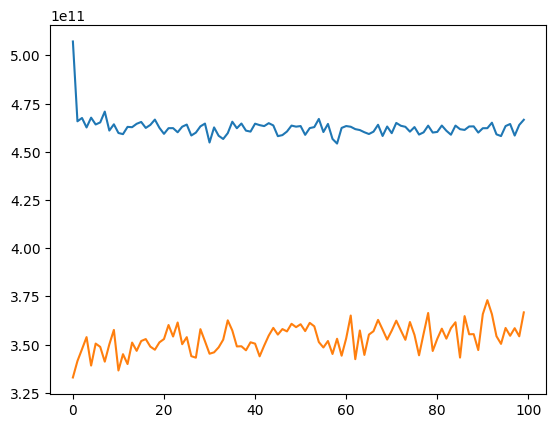

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

-0.3643543372198923


In [ ]:
import scipy.stats as stats
import seaborn as sns

In [ ]:
from array import array


def createPlots(df: any,columns: array, plot_function:any):

    cols = 2
    rows = columns.size//cols + (1 if columns.size%cols >0 else 0)
    fig, ax = plt.subplots(rows, cols, figsize=(15,20))
    for i,col in enumerate(columns):
        if rows == 1:

            plot_function(df[col], ax=ax[0,i%cols], label=col)

        else:

            plot_function(df[col], ax=ax[i//cols, i%cols], label=col)

    plt.show()

C:\Users\jayaraj\AppData\Local\Temp\ipykernel_14112\1370728427.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot_function(df[col], ax=ax[i//cols, i%cols], label=col)
C:\Users\jayaraj\AppData\Local\Temp\ipykernel_14112\1370728427.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot_function(df[col], ax=ax[i//

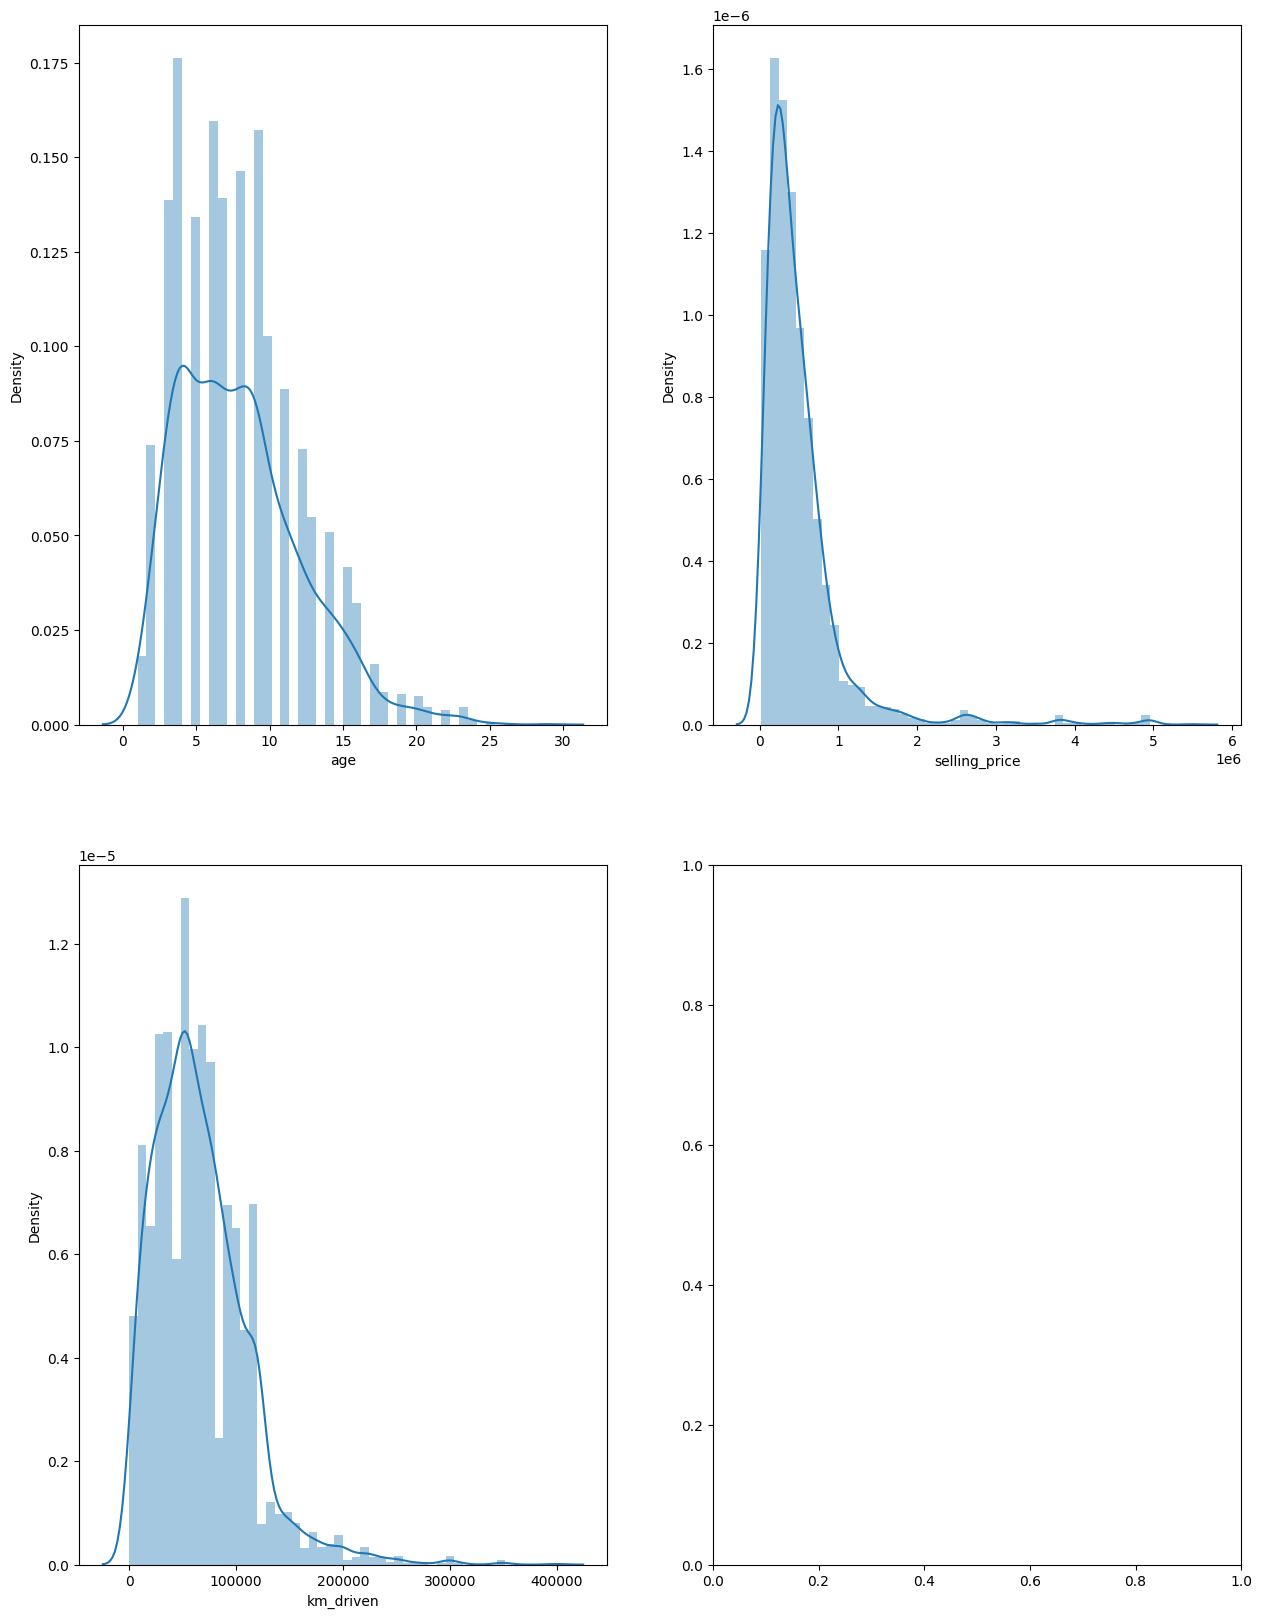

In [ ]:
import numpy as np
createPlots(df, np.array(['age', 'selling_price', 'km_driven']), plot_function=sns.distplot )

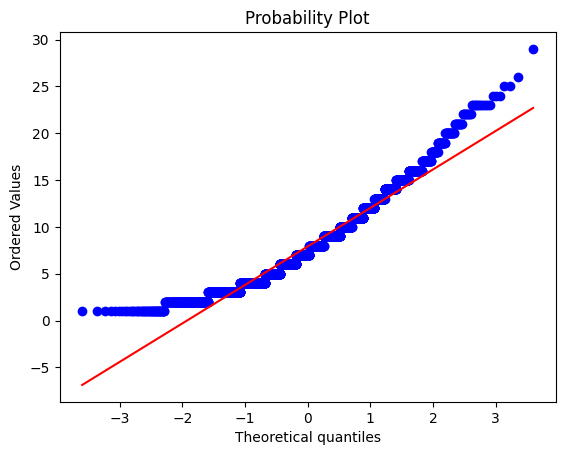

In [ ]:
stats.probplot(df['age'], dist="norm", plot=plt)
plt.show()

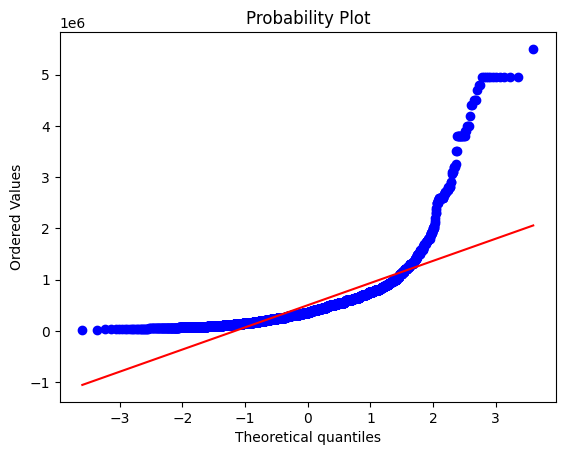

In [ ]:
stats.probplot(df['selling_price'], dist="norm", plot=plt)
plt.show()

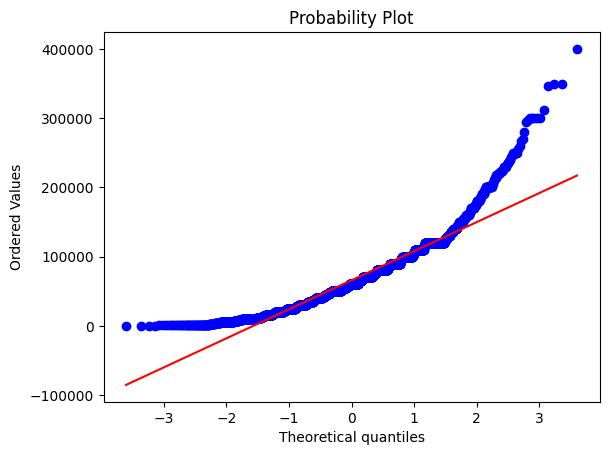

In [ ]:
stats.probplot(df['km_driven'], dist="norm", plot=plt)
plt.show()

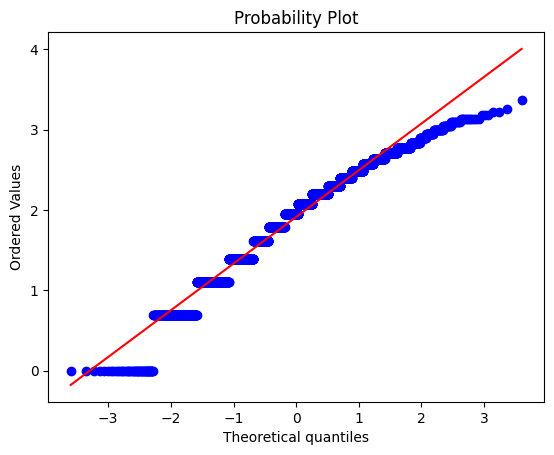

In [ ]:
import math
stats.probplot(df['age'].apply(lambda x : math.log(x)), dist="norm", plot=plt)
plt.show()

In [ ]:
df1 = df.copy()
df1.head()

,owner,age,selling_price,km_driven,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual
0,1.0,14,60000,70000,0,0,0,1,1,0,1
1,1.0,14,135000,50000,0,0,0,1,1,0,1
2,1.0,9,600000,100000,1,0,0,0,1,0,1
3,1.0,4,250000,46000,0,0,0,1,1,0,1
4,2.0,7,450000,141000,1,0,0,0,1,0,1


In [ ]:
df1['fuel_Electric'].value_counts()

0    4334
1       1
Name: fuel_Electric, dtype: int64

In [ ]:
df1['fuel_LPG'].value_counts()

0    4312
1      23
Name: fuel_LPG, dtype: int64